# 자전거 대여 수요 예측 (실습)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import bike

In [2]:
bike_df = pd.read_csv('bike_train.csv')
bike_df.shape

(10886, 12)

## 데이터 가공

In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)
print('### datetime count ###\n', bike_df['datetime'].value_counts())

# datetime 타입에서 year, month, day, hour 추출
bike_df['year'] = bike_df.datetime.apply(lambda x:x.year)
print('### year count ###\n', bike_df['year'].value_counts())
bike_df['month'] = bike_df.datetime.apply(lambda x:x.month)
print('### month count ###\n', bike_df['month'].value_counts())
bike_df['day'] = bike_df.datetime.apply(lambda x:x.day)
print('### day count ###\n', bike_df['day'].value_counts())
bike_df['hour'] = bike_df.datetime.apply(lambda x:x.hour)
print('### hour count ###\n', bike_df['hour'].value_counts())

### datetime count ###
 datetime
2011-01-01 00:00:00    1
2012-05-01 21:00:00    1
2012-05-01 13:00:00    1
2012-05-01 14:00:00    1
2012-05-01 15:00:00    1
                      ..
2011-09-02 04:00:00    1
2011-09-02 05:00:00    1
2011-09-02 06:00:00    1
2011-09-02 07:00:00    1
2012-12-19 23:00:00    1
Name: count, Length: 10886, dtype: int64
### year count ###
 year
2012    5464
2011    5422
Name: count, dtype: int64
### month count ###
 month
5     912
6     912
7     912
8     912
12    912
10    911
11    911
4     909
9     909
2     901
3     901
1     884
Name: count, dtype: int64
### day count ###
 day
1     575
9     575
17    575
5     575
16    574
15    574
14    574
13    574
19    574
8     574
7     574
4     574
2     573
12    573
3     573
6     572
10    572
11    568
18    563
Name: count, dtype: int64
### hour count ###
 hour
12    456
13    456
22    456
21    456
20    456
19    456
18    456
17    456
16    456
15    456
14    456
23    456
11    455
10    4

In [5]:
drop_columns = ['datetime', 'casual', 'registered']
select_columns = [column for column in bike_df.columns if column not in drop_columns]
backup_ = bike_df.drop(select_columns, axis=1)
bike_df = bike_df.drop(drop_columns, axis=1)

In [6]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int64  
 10  month       10886 non-null  int64  
 11  day         10886 non-null  int64  
 12  hour        10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


In [7]:
bike_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22


### Data Visualization

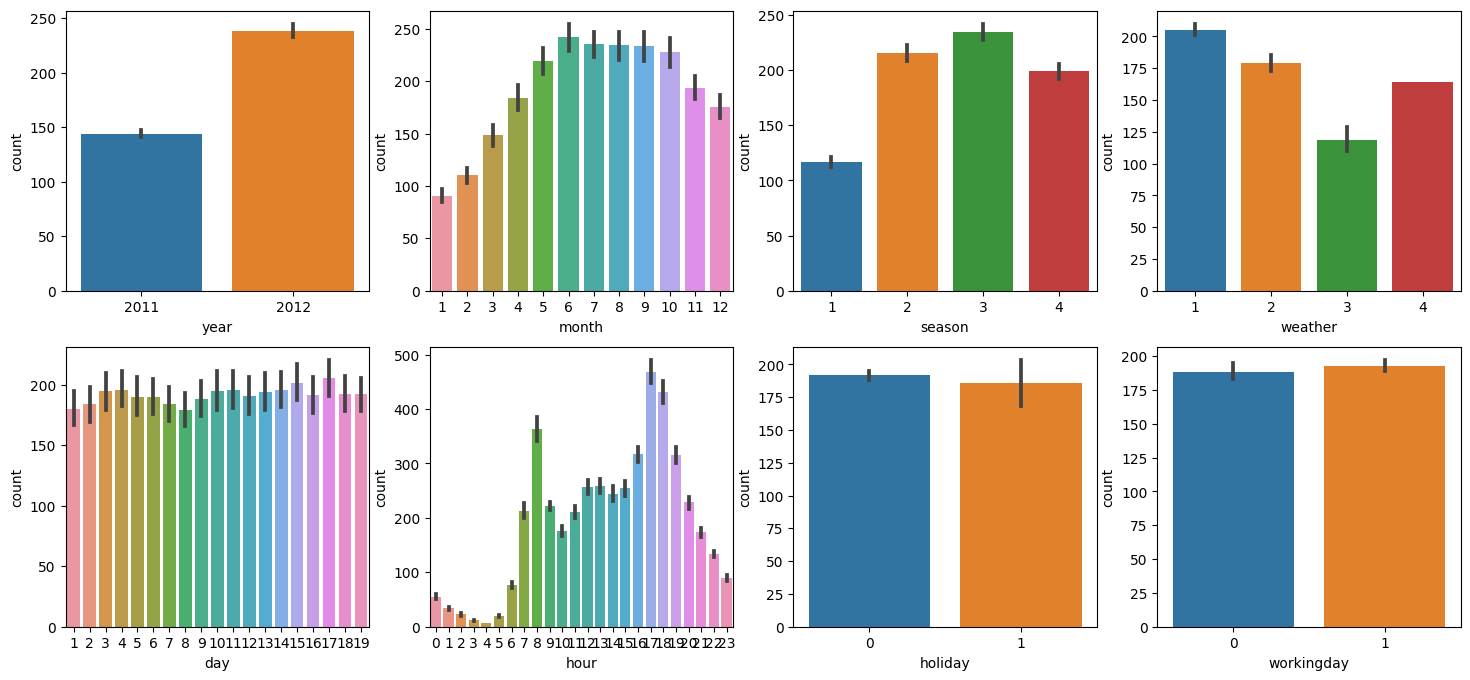

In [8]:
fig, axes = plt.subplots(figsize=(18,8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']

for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data=bike_df, ax=axes[row][col])

plt.show()

## 로그 변환, Feature Encoding, 모델 학습/예측/평가

### Linear Regression을 사용한 회귀 예측

In [9]:
y_target = bike_df['count']
x_features = bike_df.drop(['count'], axis=1)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target)

lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)
bike.evaluate_regr(y_test, pred)

r2: 0.399 RMSLE: 141.223978 RMSE:141.224 MAE: 106.259


/Users/bongeungu/Desktop/kfq/python/machine/MachineLearning/MachineLearning_Class/bike.py:9: RuntimeWarning: invalid value encountered in log1p
  log_pred = np.log1p(pred)


In [13]:
bike.get_top_error_data(y_test, pred)

      real_count  predicted_count   diff
964          835            214.0  621.0
381          731            142.0  589.0
1509         798            246.0  552.0
2512         785            236.0  549.0
1949         856            307.0  549.0


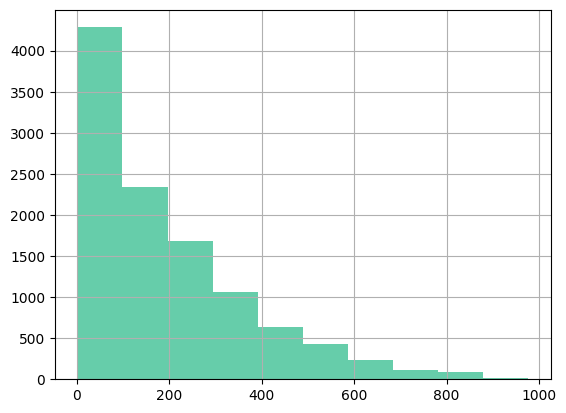

In [14]:
y_target.hist(color = 'mediumaquamarine')
plt.show()

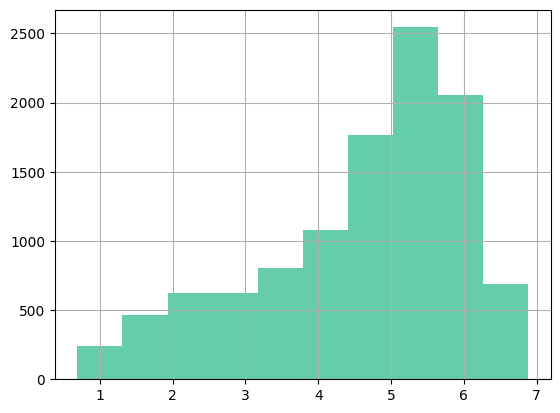

In [15]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist(color = 'mediumaquamarine')
plt.show()

In [16]:
sdf = pd.DataFrame()
sdf['yt'] = y_test
sdf['pred'] = pred

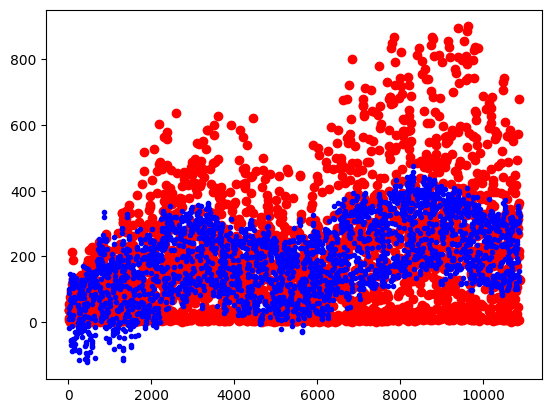

In [17]:
plt.plot(sdf.index,y_test,'ro')
plt.plot(sdf.index,pred,'b.')
plt.show()

In [18]:
#plt.plot(sdf.index,pred_yt,'ro')
#plt.plot(sdf.index,pred_exp,'b.')
#plt.show()

In [20]:
# 타깃 column인 count 값을 log1p로 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target_log)
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)

# 기존 스케일로 변환
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

bike.evaluate_regr(y_test_exp, pred_exp)

r2: 0.192 RMSLE: 161.000625 RMSE:161.001 MAE: 109.899


In [21]:
# RMSLE 오류는 감소, RMSE는 증가

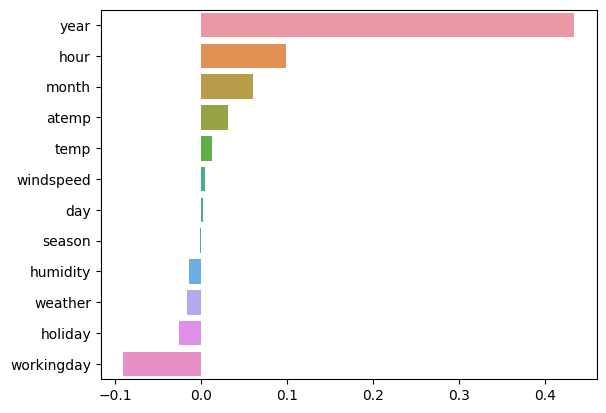

In [22]:
# 개별 Feature 들의 인코딩 적용
## Feature의 회귀 계숫값 시각화
coef = pd.Series(lr_reg.coef_, index=x_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.show()

### One Hot Encoding을 사용한 예측 성능 확인

In [23]:
column = ['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather']
x_features_ohe = pd.get_dummies(x_features, columns=column)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_features_ohe, y_target_log)

In [26]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    bike.get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
r2: 0.719 RMSLE: 97.183384 RMSE:97.183 MAE: 63.815
### Ridge ###
r2: 0.713 RMSLE: 98.278708 RMSE:98.279 MAE: 64.208
### Lasso ###
r2: 0.609 RMSLE: 114.756148 RMSE:114.756 MAE: 73.564


In [27]:
# One Hot Encoding 적용 후 Linear Regression 예측 성능 향상

<Axes: >

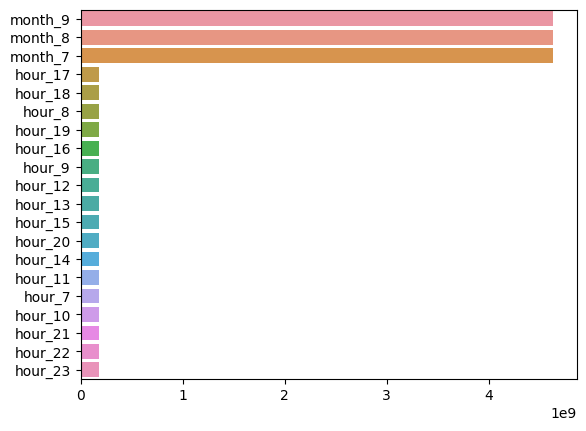

In [28]:
coef = pd.Series(lr_reg.coef_, index=x_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### Random Forest, GBM, XGBoost, LightGBM

In [29]:
rf_reg = RandomForestClassifier(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

In [30]:
for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    bike.get_model_predict(model, x_train.values, x_test.values, y_train.values, y_test.values, is_expm1=True)

ValueError: Unknown label type: 'continuous'